In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import cv2
import glob
from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
base_path = "../Data/"

In [7]:
data_path = base_path + 'cohn-kanade-images'
emotion_path = base_path + 'Emotion'
facs_path = base_path + 'FACS'
landmarks_path = base_path + 'Landmarks'
crop_path = base_path + 'Crop'

all_image_files = glob.glob(data_path+'/**/*.png', recursive=True)
all_emotion_files = glob.glob(emotion_path+'/**/*.txt', recursive=True)
all_facs_files = glob.glob(facs_path+'/**/*.txt', recursive=True)
all_landmarks_files = glob.glob(landmarks_path+'/**/*.txt', recursive=True)

In [8]:
data_path

'../Data/cohn-kanade-images'

In [9]:
# ONLY 327 of the 593 sequences have emotion sequences
# 0-7 (i.e. 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise)
all_emotions = {0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 
                4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}
all_image_files[:5], all_emotion_files[:5], all_facs_files[:5], all_landmarks_files[:5]

(['../Data/cohn-kanade-images/S111/007/S111_007_00000008.png',
  '../Data/cohn-kanade-images/S111/007/S111_007_00000009.png',
  '../Data/cohn-kanade-images/S111/007/S111_007_00000013.png',
  '../Data/cohn-kanade-images/S111/007/S111_007_00000007.png',
  '../Data/cohn-kanade-images/S111/007/S111_007_00000006.png'],
 ['../Data/Emotion/S111/007/S111_007_00000014_emotion.txt',
  '../Data/Emotion/S111/001/S111_001_00000014_emotion.txt',
  '../Data/Emotion/S111/006/S111_006_00000010_emotion.txt',
  '../Data/Emotion/S129/012/S129_012_00000011_emotion.txt',
  '../Data/Emotion/S129/006/S129_006_00000010_emotion.txt'],
 ['../Data/FACS/S111/007/S111_007_00000014_facs.txt',
  '../Data/FACS/S111/001/S111_001_00000014_facs.txt',
  '../Data/FACS/S111/006/S111_006_00000010_facs.txt',
  '../Data/FACS/S111/003/S111_003_00000012_facs.txt',
  '../Data/FACS/S111/004/S111_004_00000010_facs.txt'],
 ['../Data/Landmarks/S111/007/S111_007_00000008_landmarks.txt',
  '../Data/Landmarks/S111/007/S111_007_00000002_

In [15]:
pd.set_option('display.max_colwidth', -1)

crop_imsize = 350

def get_thumbnail(path):
    ''' function to read image'''
    i = Image.open(path)
#     i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    ''' function to encode image in base64 '''
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    ''' function to return html code for printing image in dataframe '''
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(im))

def crop_image_formatter(im):
    ''' function to read cropped image from numpy array '''
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(Image.fromarray(np.uint8(im))))

face_det = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

def print_metrics(y_test, y_pred):
    ''' just a function from data science for printing '''
    labels = dict(all_emotions)
    del labels[0]
    
    print(labels)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Classification Report: \n', classification_report(y_test, y_pred, 
                                                             target_names=[l for l in labels.values()]))
    
    conf_mat = confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(len(labels)), [l for l in labels.values()], rotation=90)
    _ = plt.yticks(range(len(labels)), [l for l in labels.values()])

# Creating Dataframe for images dataset

In [41]:
# reading all the image files, and then finding corresponding landmark, facs files and save them in a dictionary
image_dict = {}

for i_im in all_image_files:
    im_dict = {}
    im_folder = i_im.rsplit('/', 1)[0]
    if im_folder not in image_dict.keys():
        im_files = glob.glob(im_folder+'/*.png')
        im_dict['emotion'] = im_files[-1]
        im_dict['neutral'] = im_files[0]

#         im_folder_base = im_files[-1].split('/', 3)[-1].rsplit('/', 1)[0]
        im_folder_base = "/".join(im_files[-1].rsplit('/',3)[-3:]).rsplit('/',1)[0]
        facs_folder = facs_path + '/' + im_folder_base
        emotion_folder = emotion_path + '/' + im_folder_base
        landmarks_folder = landmarks_path + '/' + im_folder_base
#         print("/".join(im_files[-1].rsplit('/',3)[-3:]).rsplit('/',1)[0])
#         print(im_files[-1].split('/', 3)[-1].rsplit('/',1))
#         print(im_folder_base,facs_path, facs_folder)
        facs_file = glob.glob(facs_folder+'/*.txt')[0]
        emotion_file = glob.glob(emotion_folder+'/*.txt')
        neutral_landmarks_file = glob.glob(landmarks_folder+'/*.txt')[0]
        emotion_landmarks_file = glob.glob(landmarks_folder+'/*.txt')[-1]

        with open(facs_file) as f:
            data = f.read()
            im_dict['facs'] = np.array([list(map(float, i.split())) for i in data.strip().split('\n')])

        if len(emotion_file) > 0:
            emotion_file = emotion_file[0]
            with open(emotion_file) as f:
                data = f.read()
                im_dict['label'] = int(float(data))
                im_dict['label_str'] = all_emotions[im_dict['label']]

        with open(neutral_landmarks_file) as f:
            data = f.read()
            im_dict['neutral_landmarks'] = np.array([list(map(float, 
                                                     i.split())) for i in data.strip().split('\n')])

        with open(emotion_landmarks_file) as f:
            data = f.read()
            im_dict['emotion_landmarks'] = np.array([list(map(float, 
                                                     i.split())) for i in data.strip().split('\n')])

    #     print(im_dict)
        image_dict[im_folder] = (im_dict)

# print(len(image_dict))

In [42]:
# converting that dictionary to pandas dataframe, and applying operations on certain columns
df_images = pd.DataFrame.from_dict(image_dict).T
df_images.to_csv('ImageDict.csv', index=True)
# df_images.head()
df_images.dtypes

emotion              object
emotion_landmarks    object
facs                 object
label                object
label_str            object
neutral              object
neutral_landmarks    object
dtype: object

In [43]:
# df_images = pd.read_csv('ImageDict.csv', index_col=0, dtype=object)
# df_images.head()

In [44]:
# function to store images in df column
df_images['im_emotion'] = df_images.emotion.map(lambda f: get_thumbnail(f))
df_images['im_neutral'] = df_images.neutral.map(lambda f: get_thumbnail(f))

# function to detect faces and crop images and store in df, and also shift landmarks to cropped face
# df_images['im_emotion_crop'] = df_images.emotion.map(lambda f: detect_face(f))
# df_images['im_neutral_crop'] = df_images.neutral.map(lambda f: detect_face(f))
emotion_crop_tuple = df_images.apply(lambda row: detect_face(row.emotion, 
                                                             row.emotion_landmarks), axis=1)
df_images[['im_emotion_crop', 'emotion_crop_landmarks']] = pd.DataFrame(emotion_crop_tuple.tolist(), index=emotion_crop_tuple.index)
neutral_crop_tuple = df_images.apply(lambda row: detect_face(row.neutral, 
                                                             row.neutral_landmarks), axis=1)
df_images[['im_neutral_crop', 'neutral_crop_landmarks']] = pd.DataFrame(neutral_crop_tuple.tolist(), index=neutral_crop_tuple.index)

# df_images.head(1)


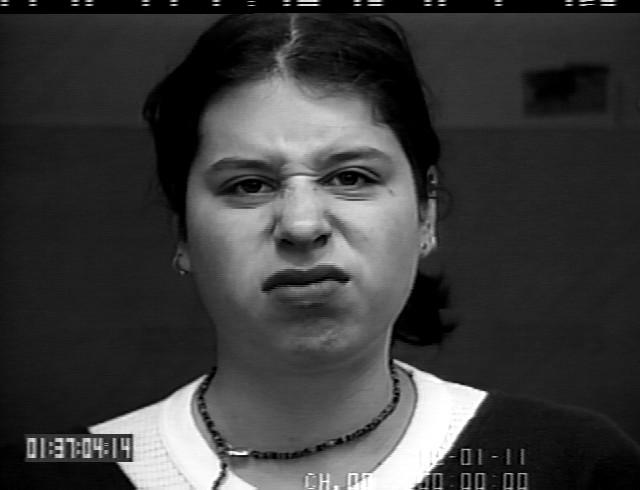
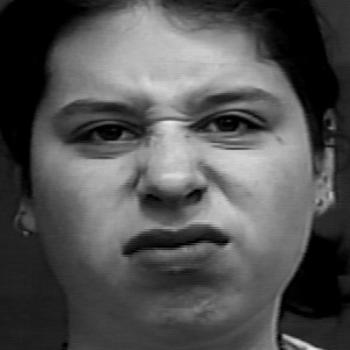
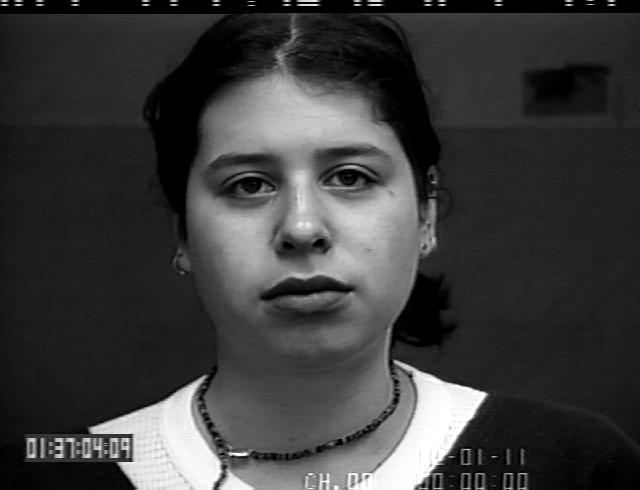
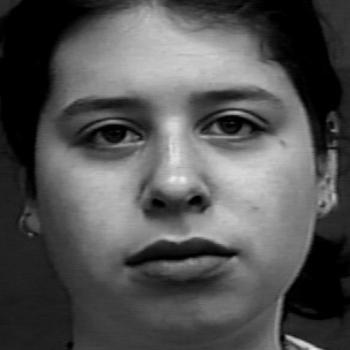
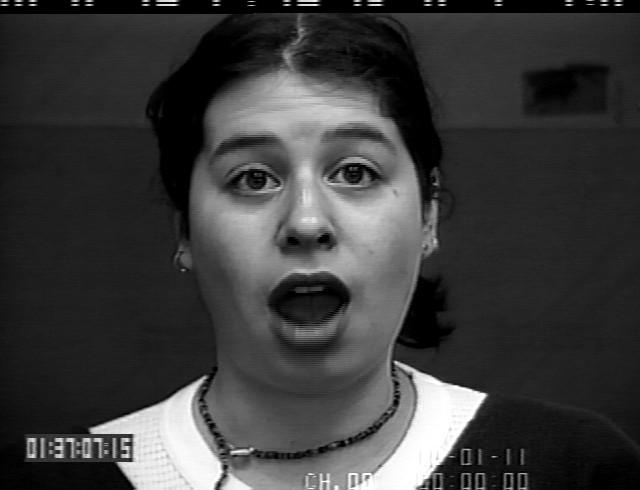
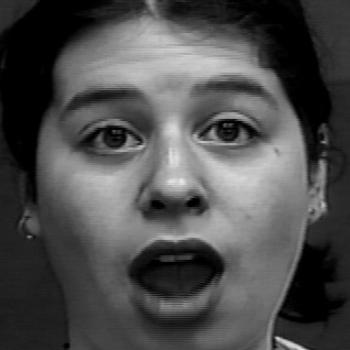
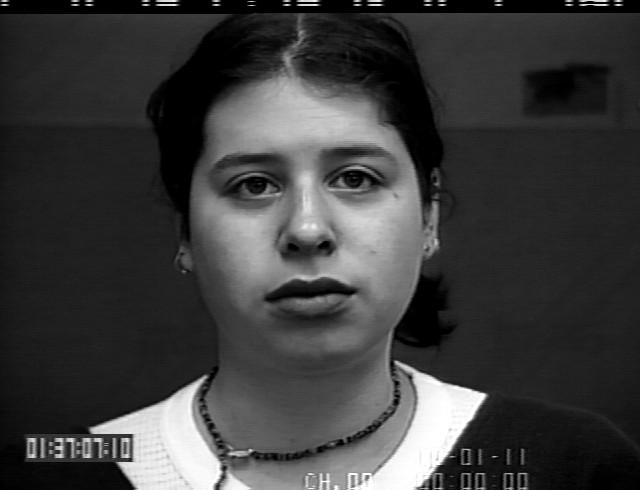
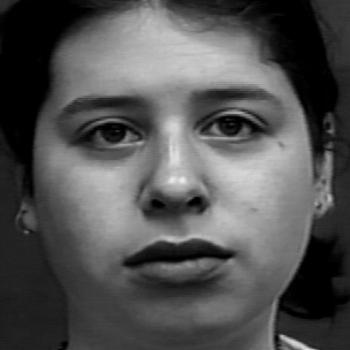
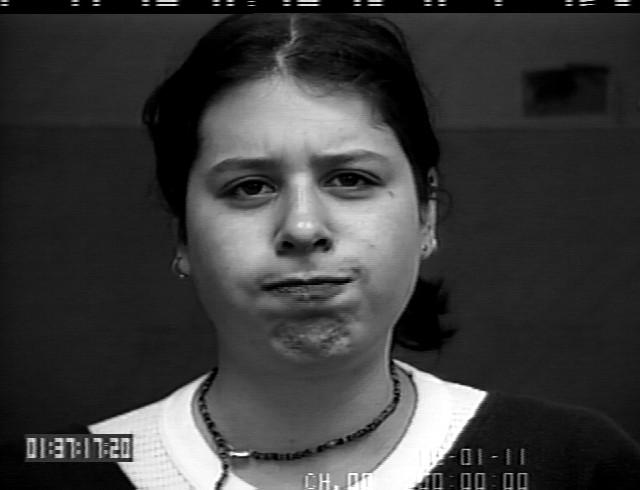
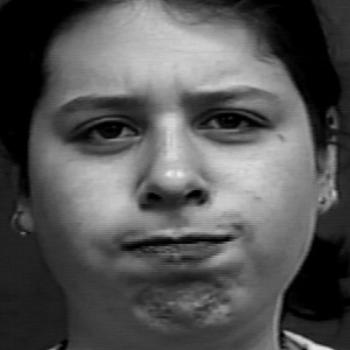
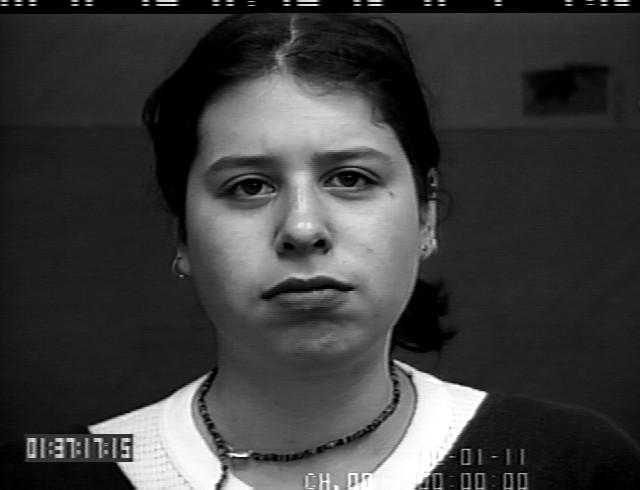
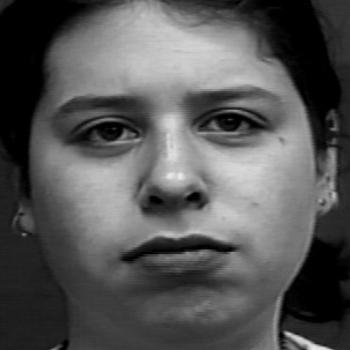
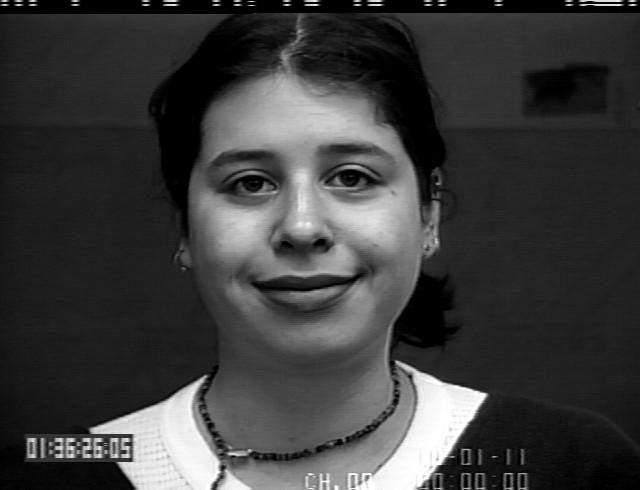
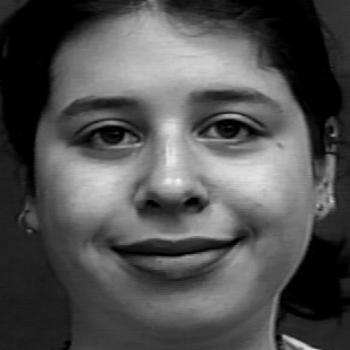
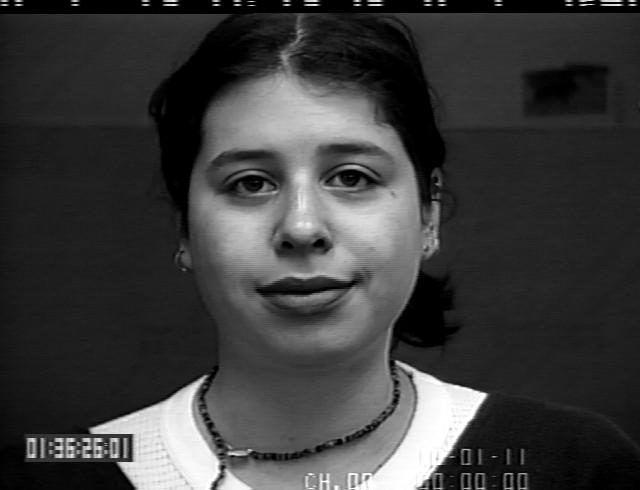
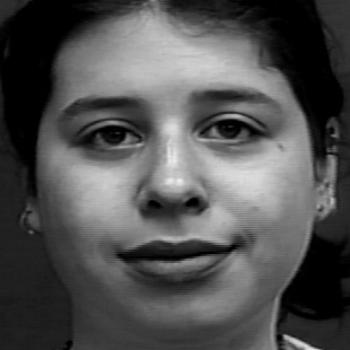
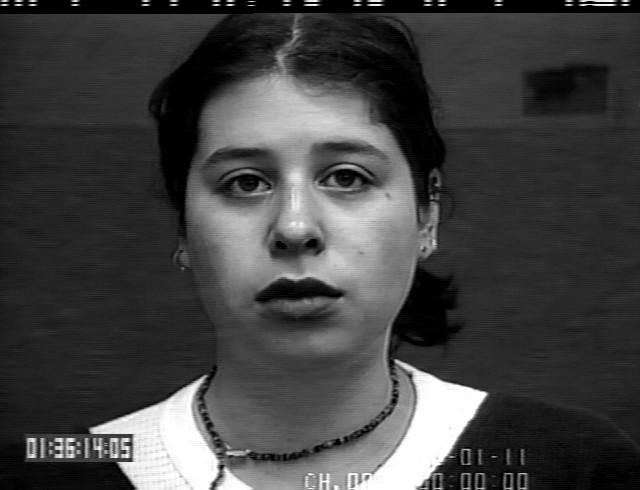
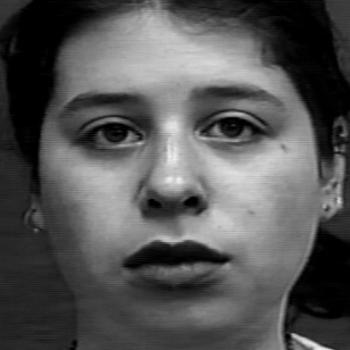
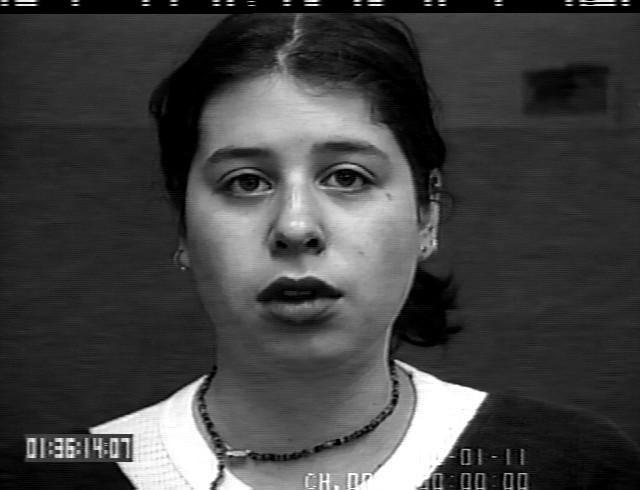
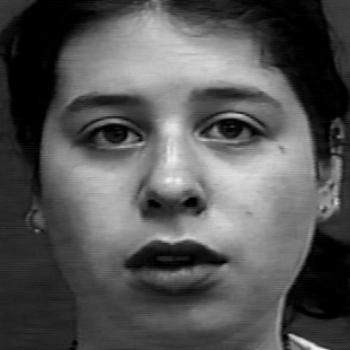

In [45]:
# displaying PIL.Image objects embedded in dataframe
HTML(df_images[['label', 'im_neutral', 'im_neutral_crop', 'im_emotion', 
                'im_emotion_crop']].head(5).to_html(formatters={'im_neutral': image_formatter, 
                                                                'im_emotion': image_formatter,
                                                                'im_neutral_crop': crop_image_formatter, 
                                                                'im_emotion_crop': crop_image_formatter}, escape=False))
# HTML(image_formatter(df_images[['im_neutral']].head(1)['im_neutral'][0]))
# df_images[['im_neutral']].head(1)['im_neutral'][0]

## Checking if landmarks fit well on the original image and cropped image that are stored in df

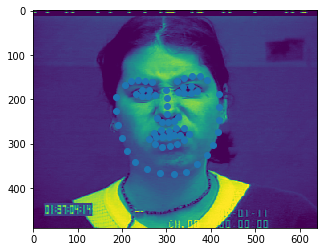

In [46]:
ld, im = df_images.head(1)[['neutral_landmarks', 'neutral']].values[0]
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

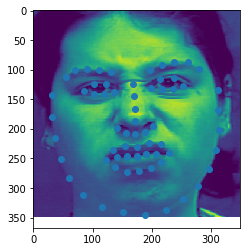

In [47]:
ld, im = df_images.head(1)[['neutral_crop_landmarks', 'im_neutral_crop']].values[0]
implot = plt.imshow(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

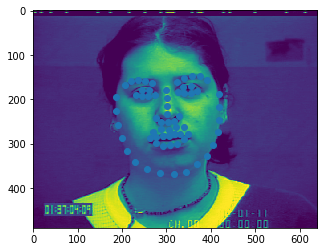

In [48]:
ld, im = df_images.head(1)[['emotion_landmarks', 'emotion']].values[0]
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

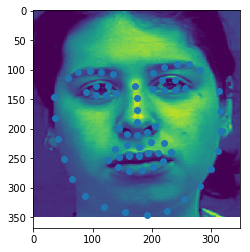

In [49]:
ld, im = df_images.head(1)[['emotion_crop_landmarks', 'im_emotion_crop']].values[0]
implot = plt.imshow(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

### Trial code for checking landmark after cropping image, Code already added in df above, ignore few cells below

354 442
368 442
False
(68, 2) (309, 295)
(0.6555555555555556, 0.6866666666666666)
(450, 450)
(309, 295)


/miniconda2/envs/PGround/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


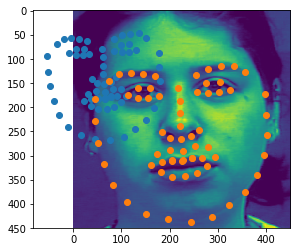

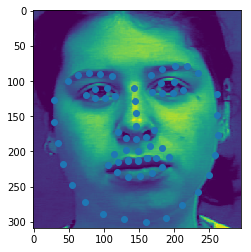

In [50]:
ld, im = df_images.head(1)[['emotion_landmarks', 'emotion']].values[0]

frame = cv2.imread(im) #Open image
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
face_det = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, w, h) in face:
    fw, fh = w, h
    if any(ld[:,0] > x+w):
        fw = int(max(ld[:,0]-x))
    if any(ld[:,1] > y+h):
        fh = int(max(ld[:,1]-y))
    print(y+h, x+w)
    print(y+fh, x+fw)
    gray1 = gray[y:y+h, x:x+w] #Cut the frame to size
    gray = gray[y:y+fh+10, x:x+fw+10] #Cut the frame to size
    print(gray1 == gray)
    
output = gray
try:
    output = cv2.resize(gray, (450, 450))
except:
    output = gray
# ldxx = cv2.resize(ld, (450, 450))
ldxx = np.copy(ld)
print(ldxx.shape, gray.shape)
# ldxx[:,0] = ld[:,0]/gray.shape[1]*450
# ldxx[:,1] = ld[:,1]/gray.shape[0]*450
crop_imsize = 450
ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
crop_ld = crop_ld/ld_rescale_factor
print(ld_rescale_factor)
print(output.shape)
print(gray.shape, )

plt.imshow(Image.fromarray(np.uint8(output)))
plt.scatter([ldxx[i][0]-x/gray.shape[1]*450 for i in range(68)], [ldxx[i][1]-y/gray.shape[0]*450 for i in range(68)])
plt.scatter([crop_ld[i][0] for i in range(68)], [crop_ld[i][1] for i in range(68)])
plt.show()
plt.imshow(Image.fromarray(np.uint8(gray)))
plt.scatter([ld[i][0]-x for i in range(68)], [ld[i][1]-y for i in range(68)])
plt.show()

In [51]:
ld = np.array(ld)

In [52]:
max(ld[:,0]-y-w)

65.47735999999998

In [53]:
x+w, y+h, w, h

(442, 354, 285, 285)

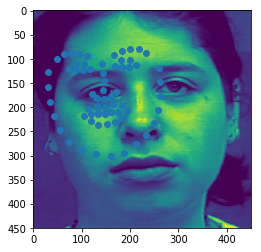

In [54]:
plt.imshow(Image.fromarray(np.uint8(output)))
plt.scatter(ld[:,0]-x, ld[:, 1]-y)

In [55]:
max(ld[:, 1]-y)

299.89055

### Trial code for flipping image, final code added below

In [56]:
df_cnn = df_images[~df_images['label'].isna()][['im_emotion_crop', 'label']]

In [57]:
X, y = df_cnn['im_emotion_crop'], df_cnn['label']

In [58]:
X.shape, y.shape

((327,), (327,))

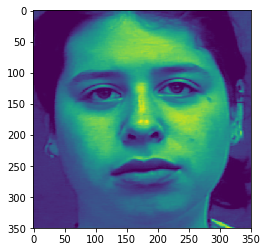

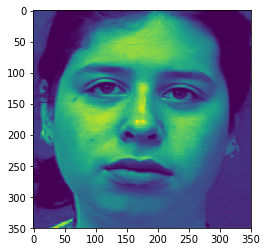

In [59]:
plt.imshow(X[0])
plt.show()
plt.imshow(np.fliplr(X[0]))

# Creating Emotion images and label as dataset
### Note: Neutral faces are not taken into account

# Flipping images and combining to increase dataset

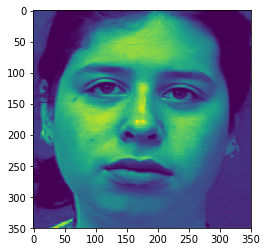

In [60]:
X_flip = X.apply(lambda x: np.fliplr(x))
plt.imshow(X_flip[0])

In [61]:
# X_total = X.reset_index(drop=True)
# y_total = to_categorical(y)
X_total = pd.concat([X.reset_index(drop=True), X_flip.reset_index(drop=True)], axis=0).reset_index(drop=True)
X_total = np.array([i for i in X_total])
# X_total = X_total.reshape(X_total.shape[0], crop_imsize, crop_imsize, 1)
y_total = to_categorical(pd.concat([y, y], axis=0).reset_index(drop=True))

X_total.shape, y_total.shape

((654, 350, 350), (654, 8))

In [62]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((523, 350, 350), (131, 350, 350), (523, 8), (131, 8))

# Creating keras CNN model (Doesn't work well, stopped after running a while)

In [63]:
# #create model
# model = Sequential()

# #add model layers
# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(crop_imsize, crop_imsize, 1)))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(Conv2D(16, kernel_size=3, activation='relu'))
# model.add(Flatten())
# model.add(Dense(8, activation='softmax'))

# #compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
# model = Sequential()
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(crop_imsize, crop_imsize, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(8, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
# #train the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=100)

In [32]:
# y_pred = model.predict(X_test)

In [33]:
# print_metrics(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [34]:
# y_test.argmax(axis=1)

In [35]:
# y_test[0]

In [36]:
# model.summary()

# Using cv2 Fisher Face Recognizer for expression recognition (not face)

In [66]:
fishface = cv2.face.FisherFaceRecognizer_create() #Initialize fisher face classifier
fishface.train(X_train, np.asarray(y_train.argmax(axis=1)))
correct = 0
incorrect = 0
for cnt, image in enumerate(X_test):
    pred, conf = fishface.predict(image)
    if pred == y_test.argmax(axis=1)[cnt]:
        correct += 1
#         cnt += 1
    else:
        incorrect += 1
#         cnt += 1
print((100*correct)/(correct + incorrect))

53.43511450381679


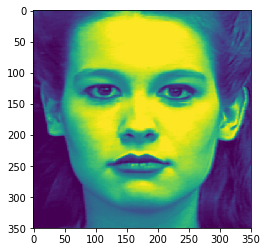

In [67]:
plt.imshow(X_test[10])

In [68]:
fishface.predict(X_test[10]), y_test[10]

((3, 399.5540021602783),
 array([0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [69]:
all_emotions

{0: 'neutral',
 1: 'anger',
 2: 'contempt',
 3: 'disgust',
 4: 'fear',
 5: 'happy',
 6: 'sadness',
 7: 'surprise'}

# Using landmarks for detecting emotion (In progress, not done)

In [70]:
df_images.columns

Index(['emotion', 'emotion_landmarks', 'facs', 'label', 'label_str', 'neutral',
       'neutral_landmarks', 'im_emotion', 'im_neutral', 'im_emotion_crop',
       'emotion_crop_landmarks', 'im_neutral_crop', 'neutral_crop_landmarks'],
      dtype='object')

In [71]:
df_landmarks = df_images[~df_images['label'].isna()][['emotion_landmarks', 'label']]
X, y = df_landmarks['emotion_landmarks'], df_landmarks['label']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((261,), (66,), (261,), (66,))

In [73]:
# X_train.head(2).values

In [74]:
# [i[0][0] for i in X_train], [i[0][1] for i in X_train]#, [i[1] for i in X_train.head(1).values[0]]

In [75]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score

# dt = DecisionTreeClassifier()
# res = cross_val_score(dt, X, y, cv=10)
# print(res)

# Generate triangle

In [76]:
import random

# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Draw a point
def draw_point(img, p, color ) :
    cv2.circle( img, p, 2, color, cv2.FILLED, cv2.LINE_AA, 0 )
 
 
# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color ) :
 
    triangleList = subdiv.getTriangleList();
    size = img.shape
    r = (0, 0, size[1], size[0])
 
    for t in triangleList :
         
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
         
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
         
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)
 
 
# Draw voronoi diagram
def draw_voronoi(img, subdiv) :
 
    ( facets, centers) = subdiv.getVoronoiFacetList([])
 
    for i in range(0,len(facets)) :
        ifacet_arr = []
        for f in facets[i] :
            ifacet_arr.append(f)
         
        ifacet = np.array(ifacet_arr, np.int)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
 
        cv2.fillConvexPoly(img, ifacet, color, cv2.LINE_AA, 0);
        ifacets = np.array([ifacet])
        cv2.polylines(img, ifacets, True, (0, 0, 0), 1, cv2.LINE_AA, 0)
        cv2.circle(img, (centers[i][0], centers[i][1]), 3, (0, 0, 0), cv2.FILLED, cv2.LINE_AA, 0)

In [77]:
df_images.columns

Index(['emotion', 'emotion_landmarks', 'facs', 'label', 'label_str', 'neutral',
       'neutral_landmarks', 'im_emotion', 'im_neutral', 'im_emotion_crop',
       'emotion_crop_landmarks', 'im_neutral_crop', 'neutral_crop_landmarks'],
      dtype='object')

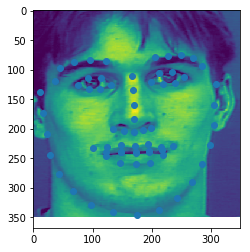

In [78]:
row = 42
# ld, im = df_images.head(1)[['emotion_landmarks', 'im_emotion']].values[0]
ld, im = df_images.head(100)[['emotion_crop_landmarks', 'im_emotion_crop']].values[row]
im = np.array(im)
implot = plt.imshow(im)
im_em = np.copy(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

In [79]:
points = [(int(i[0]), int(i[1])) for i in ld]
sshape = np.array (points, np.float32)
sshape = sshape.reshape (1, -1, 2)

# This is how you can add one point. 
# points.append((x, y))

size = im.shape
rect = (0, 0, size[1], size[0])

subdiv  = cv2.Subdiv2D(rect); 
for p in points:
    subdiv.insert(p)
triangleList = subdiv.getTriangleList()

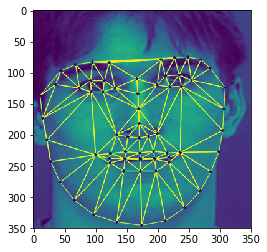

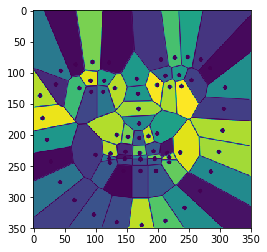

In [80]:
# Draw delaunay triangles
draw_delaunay(im, subdiv, (255, 255, 255) );

# Draw points
for p in points:
    draw_point(im, p, (0,0,255))

# Allocate space for Voronoi Diagram
img_voronoi = np.zeros(im.shape, dtype = im.dtype)

# Draw Voronoi diagram
draw_voronoi(img_voronoi,subdiv)

# cv2.imshow(win_delaunay,im)
# cv2.imshow(win_voronoi,img_voronoi)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(im)
plt.show()
plt.imshow(img_voronoi)
plt.show()

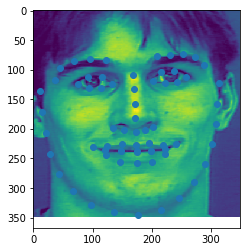

In [81]:
ld, im = df_images.head(100)[['neutral_crop_landmarks', 'im_neutral_crop']].values[row]

im = np.array(im)
implot = plt.imshow(im)
im_n = np.copy(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

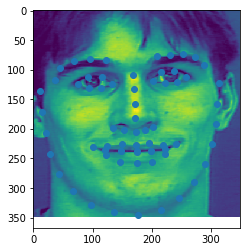

In [82]:
ld, im = df_images.head(100)[['neutral_crop_landmarks', 'im_neutral_crop']].values[row]

im = np.array(im)
implot = plt.imshow(im)
im_n = np.copy(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

In [83]:
points = [(int(i[0]), int(i[1])) for i in ld]
tshape = np.array (points, np.float32)
tshape = tshape.reshape (1, -1, 2)

# This is how you can add one point. 
# points.append((x, y))

size = im.shape
rect = (0, 0, size[1], size[0])

subdiv  = cv2.Subdiv2D(rect); 
for p in points:
    subdiv.insert(p)
triangleList = subdiv.getTriangleList()

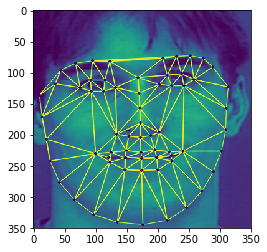

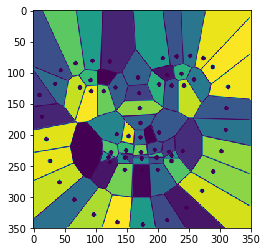

In [84]:
# Draw delaunay triangles
draw_delaunay(im, subdiv, (255, 255, 255) );

# Draw points
for p in points:
    draw_point(im, p, (0,0,255))

# Allocate space for Voronoi Diagram
img_voronoi = np.zeros(im.shape, dtype = im.dtype)

# Draw Voronoi diagram
draw_voronoi(img_voronoi,subdiv)

# cv2.imshow(win_delaunay,im)
# cv2.imshow(win_voronoi,img_voronoi)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(im)
plt.show()
plt.imshow(img_voronoi)
plt.show()

# Double TPSW (for trial coding by ourself instead of library, not used)

In [85]:
probe_ld = np.ones((len(ld), 3))
probe_ld[:, 1:] = ld
probe_ld[:5]

array([[  1.        ,  10.35869767, 136.20717061],
       [  1.        ,  14.57614341, 171.98200676],
       [  1.        ,  21.51346899, 207.39990203],
       [  1.        ,  27.84983915, 242.67263007],
       [  1.        ,  42.57138178, 276.13158953]])

In [86]:
def landmark_dist(p1, p2):
    return np.linalg.norm(p1 - p2)

def kernel_func(p1, p2):
    r = landmark_dist(p1, p2)
    return r**2*np.log10(r**2)

landmark_dist(probe_ld[0], probe_ld[1])
kernel_func(probe_ld[0], probe_ld[1])

4039.7028964977453

In [87]:
mat_K = np.zeros((len(ld), len(ld)))
for i in range(mat_K.shape[0]):
    for j in range(mat_K.shape[1]):
        if i != j:
            mat_K[i, j] = kernel_func(probe_ld[i], probe_ld[j])
mat_K

array([[     0.        ,   4039.7028965 ,  19293.47820775, ...,
        213786.98976678, 171658.70656589, 130430.18178954],
       [  4039.7028965 ,      0.        ,   4057.18890664, ...,
        175547.2236948 , 134791.3195605 ,  95920.60993542],
       [ 19293.47820775,   4057.18890664,      0.        , ...,
        146073.03642185, 107269.34624441,  71339.6494598 ],
       ...,
       [213786.98976678, 175547.2236948 , 146073.03642185, ...,
             0.        ,   1626.52116608,   8908.31582333],
       [171658.70656589, 134791.3195605 , 107269.34624441, ...,
          1626.52116608,      0.        ,   2063.93458984],
       [130430.18178954,  95920.60993542,  71339.6494598 , ...,
          8908.31582333,   2063.93458984,      0.        ]])

In [88]:
mat_Z = np.zeros((3,3))
mat_P = probe_ld
mat_P_T = probe_ld.T
# mat_Z, mat_P, mat_P_T

In [89]:
mat_L = np.array([[mat_K, mat_P],
                  [mat_P_T, mat_Z]])
mat_L.shape, mat_L[0,0].shape, mat_L[0,1].shape, mat_L[1,0].shape, mat_L[1,1].shape

((2, 2), (68, 68), (68, 3), (3, 68), (3, 3))

# TPS using OpenCV (Thin Plate Spline Method)
URL: https://qiita.com/SousukeShimoyama/items/2bf8defb2d057bb8b742

In [90]:
tps = cv2.createThinPlateSplineShapeTransformer ()
matches = list ()
for i in range(len(ld)):
    matches.append (cv2.DMatch (i, i, 0))

In [91]:
tps.estimateTransformation(sshape, tshape, matches)
ret, tshape_ = tps.applyTransformation (sshape)
# tshape_ - tshape

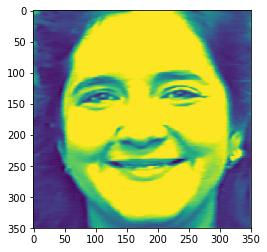

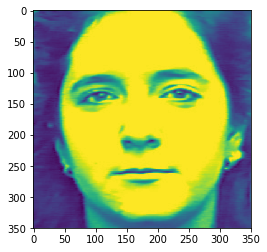

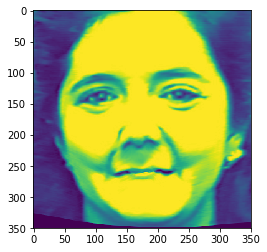

In [66]:
tps.estimateTransformation(tshape, sshape, matches)
out_img = tps.warpImage(im_em)

plt.imshow(im_em)
plt.show()
plt.imshow(im_n)
plt.show()
plt.imshow(out_img)
plt.show()

In [67]:
out_img

array([[157, 152, 148, ...,  74,  76,  74],
       [137, 131, 123, ...,  69,  70,  69],
       [120, 115, 109, ...,  68,  69,  68],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

### Divide face into 2 parts (upper lips part, and lower lips part) and then apply warping

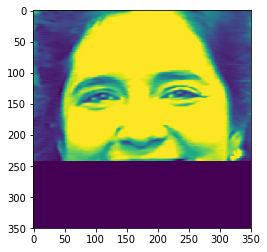

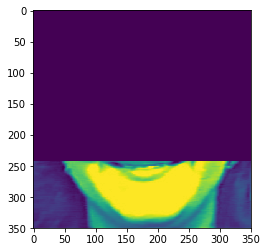

In [68]:
im_upper = np.zeros((im_em.shape))
im_upper[:int(sshape[0,48,1]),:] = im_em[:int(sshape[0,48,1]),:]

im_lower = np.zeros((im_em.shape))
im_lower[int(sshape[0,48,1]):,:] = im_em[int(sshape[0,48,1]):,:]
plt.imshow(im_upper)
plt.show()
plt.imshow(im_lower)
plt.show()

100.0


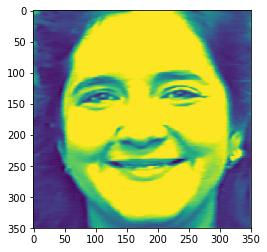

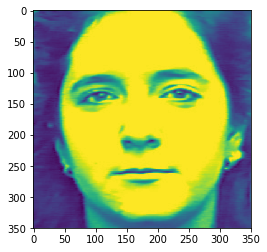

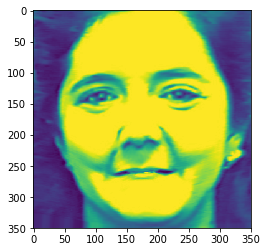

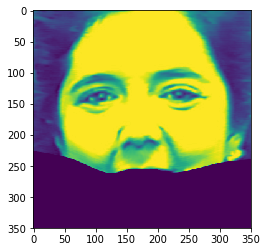

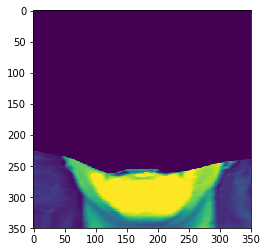

In [69]:
WARP_FLAG = 3
BORDER_CONSTANT = 1
tps.setRegularizationParameter(100)

tps.estimateTransformation(tshape, sshape, matches)
out_img = tps.warpImage(im_em, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)
out_upper = tps.warpImage(im_upper, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)
out_lower = tps.warpImage(im_lower, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)

print(tps.getRegularizationParameter())
plt.imshow(im_em)
plt.show()
plt.imshow(im_n)
plt.show()
plt.imshow(out_img)
plt.show()
plt.imshow(out_upper)
plt.show()
plt.imshow(out_lower)
plt.show()

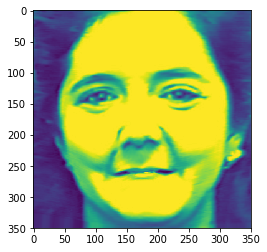

In [70]:
im_new = out_upper + out_lower
plt.imshow(im_new)
plt.show()

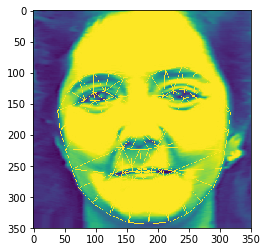

In [71]:
size = im_new.shape
rect = (0, 0, size[1], size[0])

subdiv  = cv2.Subdiv2D(rect); 
for p in tshape[0]:
    subdiv.insert((int(p[0]), int(p[1])))
triangleList = subdiv.getTriangleList()

im_tri = np.copy(im_new)
draw_delaunay(im_tri, subdiv, (255, 255, 255));

plt.imshow(im_tri)
plt.show()

In [72]:
len(triangleList)

138

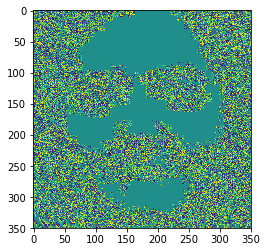

In [73]:
plt.imshow(out_img-im_new)

In [74]:
cv2.imwrite('orig.jpg', im_n)
cv2.imwrite('oemotion.jpg', im_em)
cv2.imwrite('oedit.jpg', im_new)

True

# Converting TPS code into function

In [75]:
test_row = df_images[~df_images['label'].isna()][['im_neutral_crop', 'im_emotion_crop', 
                                                  'neutral_crop_landmarks', 
                                                  'emotion_crop_landmarks']].iloc[2]
# test_row

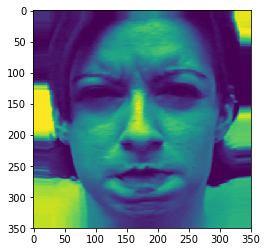

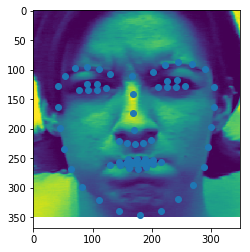

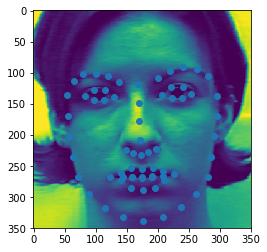

In [76]:
WARP_FLAG = 3
BORDER_CONSTANT = 1
tps = cv2.createThinPlateSplineShapeTransformer()
tps.setRegularizationParameter(100)

def apply_TPS(row, tps):
    ld_neutral, ld_emotion, im_em = row['neutral_crop_landmarks'], row['emotion_crop_landmarks'], row['im_emotion_crop']
    
    points = [(int(i[0]), int(i[1])) for i in ld_emotion]
    sshape = np.array (points, np.float32)
    sshape = sshape.reshape(1, -1, 2)
    
    points = [(int(i[0]), int(i[1])) for i in ld_neutral]
    tshape = np.array(points, np.float32)
    tshape = tshape.reshape (1, -1, 2)

    matches = list()
    for i in range(len(ld_neutral)):
        matches.append(cv2.DMatch (i, i, 0))
        
    im_upper = np.zeros((im_em.shape))
    im_upper[:int(sshape[0,48,1]),:] = im_em[:int(sshape[0,48,1]),:]

    im_lower = np.zeros((im_em.shape))
    im_lower[int(sshape[0,48,1]):,:] = im_em[int(sshape[0,48,1]):,:]

    WARP_FLAG = 3
    BORDER_CONSTANT = 1

#     plt.imshow(im_upper)
#     plt.show()
#     plt.imshow(im_lower)
#     plt.show()
    tps.estimateTransformation(tshape, sshape, matches)

    out_img = tps.warpImage(im_em, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)
    out_upper = tps.warpImage(im_upper, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)
    out_lower = tps.warpImage(im_lower, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)

    im_combine = out_upper + out_lower
    return im_combine
#     return out_img

out_im = apply_TPS(test_row, tps)
plt.imshow(out_im)
plt.show()
plt.imshow(test_row['im_emotion_crop'])
plt.scatter([test_row['emotion_crop_landmarks'][i][0] for i in range(68)], 
            [test_row['emotion_crop_landmarks'][i][1] for i in range(68)])
plt.show()
plt.imshow(test_row['im_neutral_crop'])
plt.scatter([test_row['neutral_crop_landmarks'][i][0] for i in range(68)], 
            [test_row['neutral_crop_landmarks'][i][1] for i in range(68)])
plt.show()

# Comparing Images for similarity

In [77]:
# from skimage.measure import structural_similarity as ssim
# # import the necessary packages
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")

    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")

    # show the images
    plt.show()

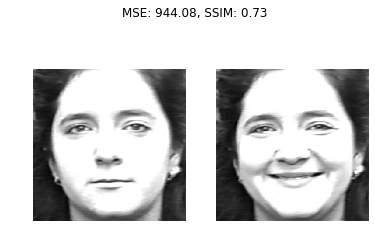

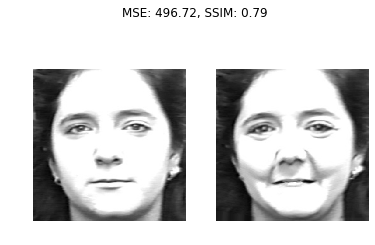

In [78]:
compare_images(im_n, im_em, 'Original vs Emotion')
compare_images(im_n, out_img, 'Original vs Warped')
# compare_images(im_n, im_new, 'Original vs join Warped')

# Training face recognizer on emotion and emotionless images

In [79]:
df_train = df_images[~df_images['label'].isna()][['im_neutral_crop', 'im_emotion_crop', 
                                                  'neutral_crop_landmarks', 'emotion_crop_landmarks']]
label_string = df_train.index
label_string = label_string.str.split('/')
df_train['label'] = [int(i[-2][1:]) for i in label_string]
df_train.reset_index(drop=True, inplace=True)
df_train['im_emotionless'] = df_train.apply(lambda row: apply_TPS(row, tps), axis=1)

In [80]:
X, y = df_train[['im_neutral_crop', 'im_emotion_crop', 'im_emotionless']], df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.reset_index(drop=True, inplace=True), X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True), y_test.reset_index(drop=True, inplace=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219, 3), (108, 3), (219,), (108,))

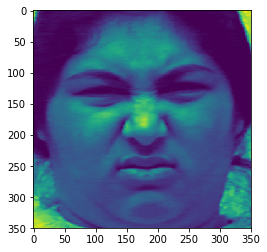

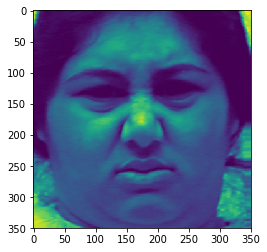

In [81]:
plt.imshow(df_train.loc[0]['im_emotion_crop'])
plt.show()
plt.imshow(df_train.loc[0]['im_emotionless'])
plt.show()

# Fisher face recognizer

In [87]:
fishface = cv2.face.FisherFaceRecognizer_create() #Initialize fisher face classifier
fishface.train(X_train['im_neutral_crop'], np.array(y_train))
correct = 0
incorrect = 0
for cnt, image in enumerate(X_test['im_emotion_crop']):
    pred, conf = fishface.predict(image)
    if pred == np.array(y_test)[cnt]:
        correct += 1
    else:
        incorrect += 1
print('Emotion Acc: ', (100*correct)/(correct + incorrect))

correct = 0
incorrect = 0
for cnt, image in enumerate(X_test['im_emotionless']):
    pred, conf = fishface.predict(image)
    if pred == np.array(y_test)[cnt]:
        correct += 1
    else:
        incorrect += 1
print('Emotionless Acc: ', (100*correct)/(correct + incorrect))

Emotion Acc:  62.03703703703704
Emotionless Acc:  72.22222222222223


In [83]:
print(fishface.predict(X_test['im_emotion_crop'][10]), y_test[10], 
      fishface.predict(X_test['im_emotionless'][10]), y_test[10])

(155, 8286.467605581522) 94 (94, 4623.459203130313) 94


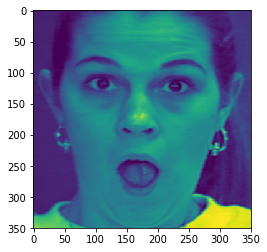

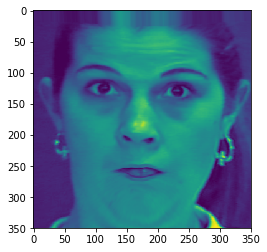

In [84]:
plt.imshow(X_test['im_emotion_crop'][10])
plt.show()
plt.imshow(X_test['im_emotionless'][10])
plt.show()

# Eigen face recognizer

In [92]:
eigenface = cv2.face.EigenFaceRecognizer_create()
eigenface.train(X_train['im_neutral_crop'], np.array(y_train))
correct = 0
incorrect = 0
for cnt, image in enumerate(X_test['im_emotion_crop']):
    pred, conf = eigenface.predict(image)
    if pred == np.array(y_test)[cnt]:
        correct += 1
    else:
        incorrect += 1
print('Emotion Acc: ', (100*correct)/(correct + incorrect))

correct = 0
incorrect = 0
for cnt, image in enumerate(X_test['im_emotionless']):
    pred, conf = eigenface.predict(image)
    if pred == np.array(y_test)[cnt]:
        correct += 1
    else:
        incorrect += 1
print('Emotionless Acc: ', (100*correct)/(correct + incorrect))

Emotion Acc:  76.85185185185185
Emotionless Acc:  78.70370370370371


In [93]:
print(eigenface.predict(X_test['im_emotion_crop'][10]), y_test[10], 
      eigenface.predict(X_test['im_emotionless'][10]), y_test[10])

(148, 13700.505127859878) 94 (94, 7521.826230905088) 94


# LBPH face recognizer

In [94]:
lbph_face = cv2.face.LBPHFaceRecognizer_create()
lbph_face.train(X_train['im_neutral_crop'], np.array(y_train))
correct = 0
incorrect = 0
for cnt, image in enumerate(X_test['im_emotion_crop']):
    pred, conf = lbph_face.predict(image)
    if pred == np.array(y_test)[cnt]:
        correct += 1
    else:
        incorrect += 1
print('Emotion Acc: ', (100*correct)/(correct + incorrect))

correct = 0
incorrect = 0
for cnt, image in enumerate(X_test['im_emotionless']):
    pred, conf = lbph_face.predict(image)
    if pred == np.array(y_test)[cnt]:
        correct += 1
    else:
        incorrect += 1
print('Emotionless Acc: ', (100*correct)/(correct + incorrect))

Emotion Acc:  84.25925925925925
Emotionless Acc:  84.25925925925925


In [95]:
print(lbph_face.predict(X_test['im_emotion_crop'][10]), y_test[10], 
      lbph_face.predict(X_test['im_emotionless'][10]), y_test[10])

(94, 27.10778924123122) 94 (94, 28.284708073899385) 94


# New Code on Combined data set

In [10]:
images_df = pd.read_pickle('../joined_images_df.pkl')

In [11]:
## Add original images to dataset
augmented_images_df = pd.DataFrame(columns=images_df.columns)

for index, image in images_df.iterrows():
    # original format, but resized
    augmented_images_df = augmented_images_df.append({
        'neutralised_image': cv2.resize(image['neutralised_image'], (160,160)), 
        'original_image': cv2.resize(image['original_image'], (160,160)), 
        'original_emotion': image['original_emotion'], 
        'name': image['name']}, 
        ignore_index=True)
    
    # swapped format and resized
    augmented_images_df = augmented_images_df.append({
        'neutralised_image': cv2.resize(image['original_image'], (160,160)), 
        'original_image': cv2.resize(image['neutralised_image'], (160,160)), 
        'original_emotion': image['original_emotion'], 
        'name': image['name']}, 
        ignore_index=True)

In [12]:
print(len(images_df), len(augmented_images_df))
augmented_images_df.head(3)

5876 11752


neutralised_image  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      original_image original_emotion name  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          disgust  111  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          disgust  111  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          disgust  111

In [16]:
print(len(images_df), len(augmented_images_df))
images_df.head(3)

5876 11752


neutralised_image  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      original_image original_emotion  name  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          disgust   111  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          disgust   111  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...          disgust   111

In [29]:
# for i in range(10):
#     plt.imshow(images_df[['original_image']].iloc[100+i].to_numpy()[0])
#     plt.show()
#     plt.imshow(images_df[['neutralised_image']].iloc[100+i].to_numpy()[0])
#     plt.show()
#     print(images_df[['original_emotion']].iloc[100+i])
#     print('*'*20)

# NEW NEW

In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import cv2
import glob
from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical

from time import gmtime, strftime

In [2]:
base_path = "../Data/"

In [3]:
ck_data_path = base_path + 'cohn-kanade-images'
ck_landmarks_path = base_path + 'Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

# ck_image_files = ck_image_files[7000:]

In [4]:
len(ck_image_files)

10708

In [5]:
all_emotions = {0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 
                4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}

In [6]:
import copy

class Image():
    
    def __init__(self, orimage, image, landmarks, neutral_landmarks, emotion, name):
        self.image = image
        self.original_image = orimage
        self.name = name
        self.emotion = emotion
        self.landmarks = landmarks
        self.neutral_landmarks = neutral_landmarks
        self.neutralised_image = np.array([])
        self.neutralised_original_image = np.array([])
        self.hash = hash(self)
    
    def getEmotion(self):
        return self.emotion
    
    def getLandmarks(self):
        return self.landmarks
    
    def setNeutralisedImage(self, image):
        self.neutralised_image = image
        
    def getNeutralisedImage(self):
        return self.neutralised_image
    
    def setNeutralisedOrImage(self, image):
        self.neutralised_original_image = image
        
    def getNeutralisedOrImage(self):
        return self.neutralised_original_image
    
    def getNeutralLandmarks(self):
        return self.neutral_landmarks
        
    def getName(self):
        return self.name
        
    def getImage(self):
        return self.image
    
    def getOrImage(self):
        return self.original_image
        
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getHash(self):
        return self.hash

In [7]:
def getLandmarksForImage(imagePath):
    cur_landmark = "/".join(str(imagePath).rsplit('/',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '/' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks

def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)

In [8]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [9]:
# from tqdm import tqdm

# images = []
# crop_imsize = 350

# with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
#     for i, ck_image in enumerate(ck_image_files):

#         landmarks = getLandmarksForImage(ck_image)
#         image, landmarks = detect_face(ck_image, landmarks)
#         image = cv2.resize(image,(crop_imsize, crop_imsize))
#         images.append(Image(image, landmarks, ck_image, ck_image))
        
#         pbar.update(1)

In [9]:
WARP_FLAG = 3
BORDER_CONSTANT = 1
tps = cv2.createThinPlateSplineShapeTransformer()
tps.setRegularizationParameter(100)

def apply_TPS(image):
    ld_neutral, ld_emotion, im_em, im_or = image.getNeutralLandmarks(), image.getLandmarks(), image.getImage(), image.getOrImage()
    
    points = [(int(i[0]), int(i[1])) for i in ld_emotion]
    sshape = np.array (points, np.float32)
    sshape = sshape.reshape(1, -1, 2)
    
    points = [(int(i[0]), int(i[1])) for i in ld_neutral]
    tshape = np.array(points, np.float32)
    tshape = tshape.reshape (1, -1, 2)

    matches = list()
    for i in range(len(ld_neutral)):
        matches.append(cv2.DMatch (i, i, 0))
        
#     im_upper = np.zeros((im_em.shape))
#     im_upper[:int(sshape[0,48,1]),:] = im_em[:int(sshape[0,48,1]),:]

#     im_lower = np.zeros((im_em.shape))
#     im_lower[int(sshape[0,48,1]):,:] = im_em[int(sshape[0,48,1]):,:]

    WARP_FLAG = 3
    BORDER_CONSTANT = 1

#     plt.imshow(im_upper)
#     plt.show()
#     plt.imshow(im_lower)
#     plt.show()
    tps.estimateTransformation(tshape, sshape, matches)

    out_img = tps.warpImage(im_em, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)
    out_original_img = tps.warpImage(im_or, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)
    image.setNeutralisedImage(out_img)
    image.setNeutralisedOrImage(out_original_img)
#     out_upper = tps.warpImage(im_upper, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)
#     out_lower = tps.warpImage(im_lower, flags=WARP_FLAG, borderMode=BORDER_CONSTANT)

#     im_combine = out_upper + out_lower
#     return im_combine
#     return out_img

# i = 40
# out_im = apply_TPS(subjects[i])
# apply_TPS(subjects[i])
# plt.imshow(subjects[i].getOrImage())
# plt.show()
# plt.imshow(subjects[i].getImage())
# plt.show()
# plt.imshow(subjects[i].getNeutralisedImage())
# plt.show()
# plt.imshow(subjects[i].getNeutralisedOrImage())
# plt.show()

def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    triangle_im = im
    triangle_mask = np.zeros_like(im)

    triangle_mask_fill_points = np.array([
            [pt1[0], pt1[1]],
            [pt2[0], pt2[1]],
            [pt3[0], pt3[1]]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
        
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
    return cropped_triangle

def cropByLandmarks(im,ld):
    landmarks = list(map(lambda x: tuple(x),ld))

    im_shape = im.shape
    
    rect = (0,0,im_shape[1],im_shape[0])
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks)
    
    triangles = subdiv.getTriangleList()
    cropped_image = np.zeros_like(im) 
    for triangle in triangles:
        triangle_image = getTriangleImage(im, triangle)      
        cropped_image = cv2.add(cropped_image, triangle_image)

    return cropped_image

# plt.imshow(images[0].getImage())
# plt.show()
# plt.imshow(cropByLandmarks(images[0].getImage(), images[0].getLandmarks()))

In [31]:
# from tqdm import tqdm

# crop_imsize = 350
# subjects = []

# with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
#     for image_path in ck_image_files:
        
#         original_image_path = base_path + "/".join(image_path.split("/")[2:])
#         landmark_path = base_path + "Landmarks/" + "/".join(image_path.split("/")[3:])[:-4] + '_landmarks.txt'
#         emotion_path = base_path + "Emotion/" + "/".join(image_path.split("/")[3:-1])
        
#         emotion_files = glob.glob(emotion_path+'/*.txt')
#         if len(emotion_files) < 1:
#             pbar.update(1)
#             continue

#         with open(emotion_files[0]) as emotion_file:
#             emotion = emotion_file.read()
#             emotion = all_emotions[(int(float(emotion)))]

#         landmarks = np.loadtxt(landmark_path)
#         # first landmark file is neutral landmarks
#         neutral_landmarks = np.loadtxt(sorted(glob.glob(landmark_path.rsplit('/', 1)[0]+'/*.txt'))[0])
        
#         # first image is neutral image
#         neutral_image_path = sorted(glob.glob(original_image_path.rsplit('/', 1)[0]+'/*.png'))[0]
        
#         neutral_image, resized_neutral_landmarks = detect_face(neutral_image_path, neutral_landmarks)  
#         neutral_image = cv2.resize(neutral_image,(crop_imsize, crop_imsize))

#         original_image, resized_landmarks = detect_face(original_image_path, landmarks)  
#         original_image = cv2.resize(original_image,(crop_imsize, crop_imsize))
        
#         crop_original_image = cropByLandmarks(original_image, resized_landmarks)

#         im_object = Image(original_image, crop_original_image, 
#                           resized_landmarks, resized_neutral_landmarks, emotion, 
#                           int((original_image_path.split("/")[-1])[:-4].split('_')[0][1:]))
# #         im_object.setNeutralisedImage(neutralised_image)
#         apply_TPS(im_object)
#         subjects.append(im_object)
#         pbar.update(1)

Processing entries: 100%|██████████| 10708/10708 [2:44:44<00:00,  1.08it/s]    


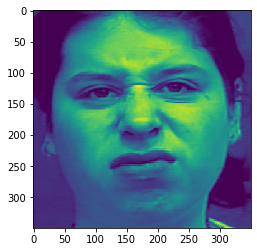

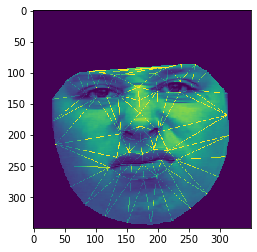

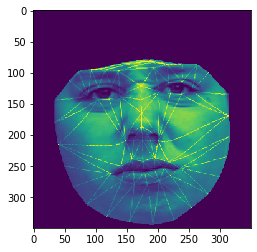

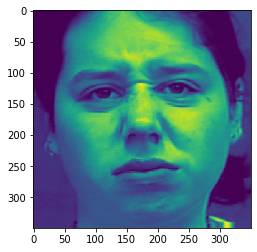

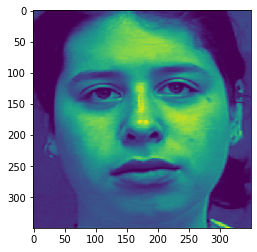

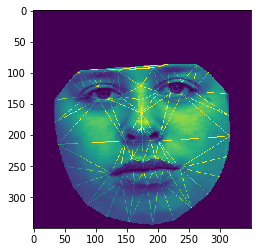

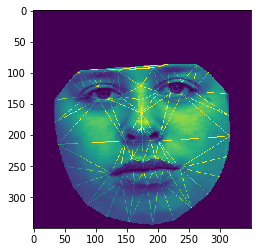

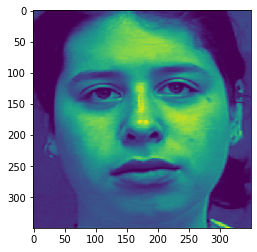

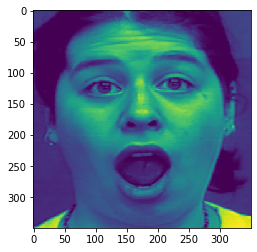

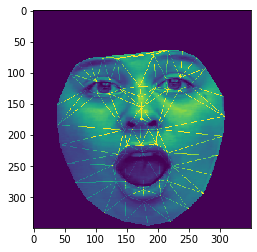

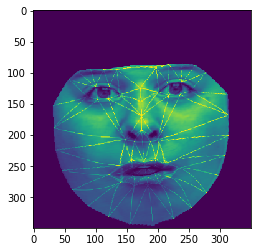

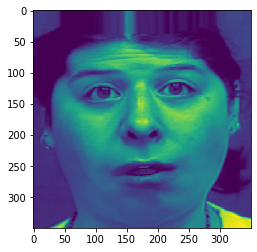

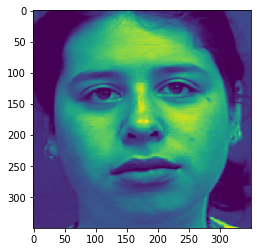

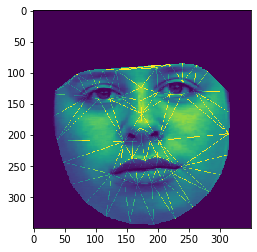

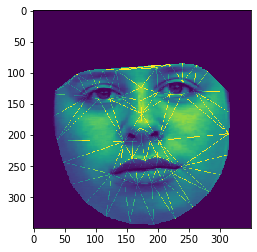

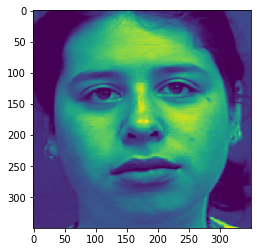

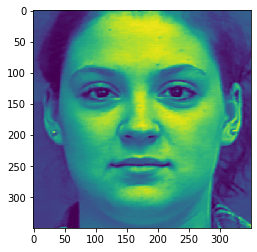

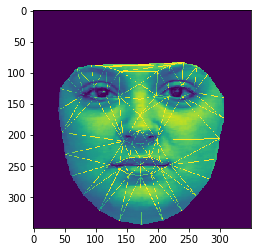

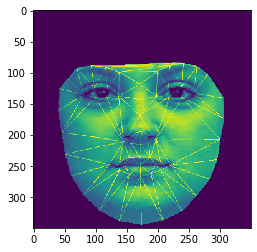

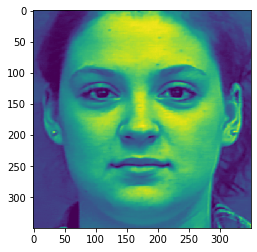

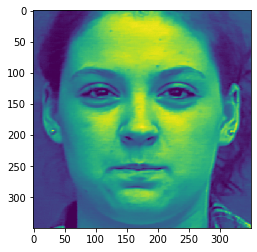

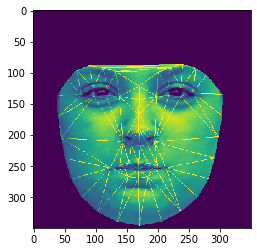

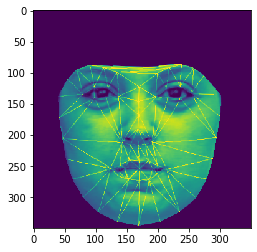

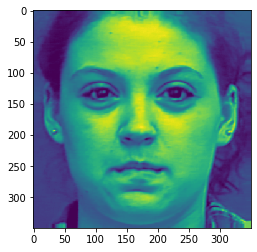

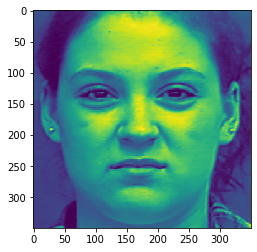

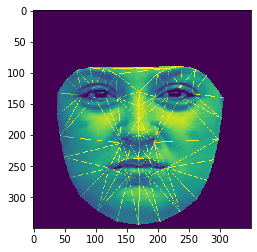

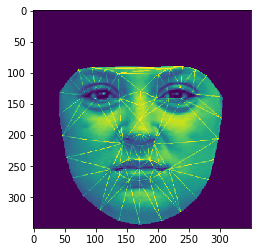

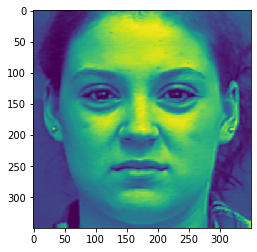

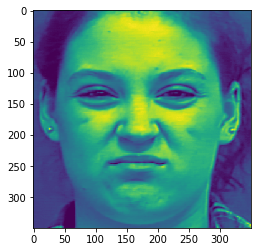

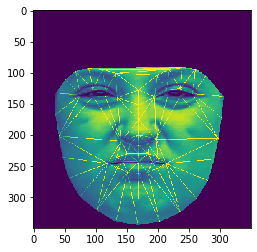

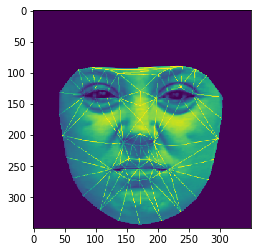

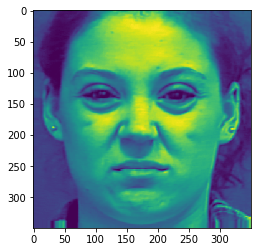

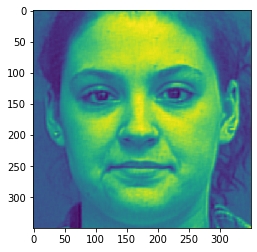

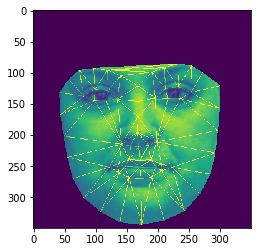

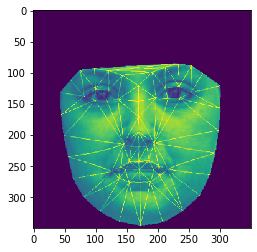

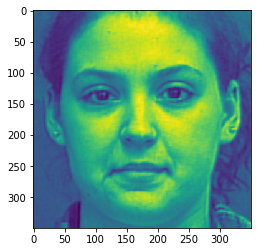

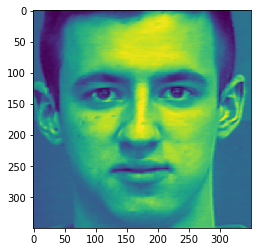

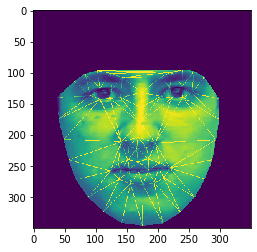

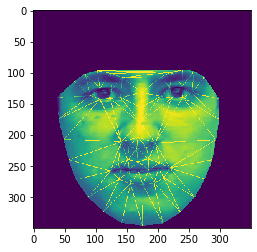

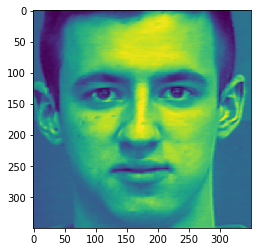

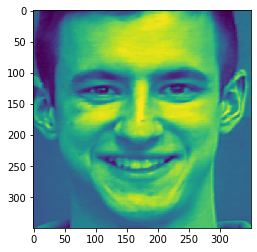

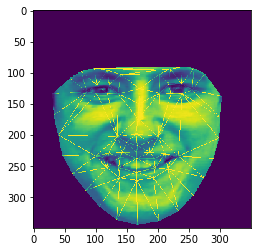

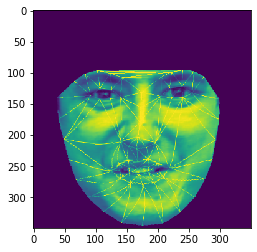

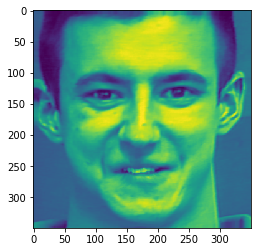

In [ ]:
# # plt.imshow(subjects[0].getOrImage())
# # plt.show()
# # plt.imshow(subjects[0].getImage())
# # plt.show()
# # plt.imshow(subjects[0].getNeutralised())
# # plt.show()
for i in range(0,101, 10):
    plt.imshow(subjects[i].getOrImage())
    plt.show()
    plt.imshow(subjects[i].getImage())
    plt.show()
    plt.imshow(subjects[i].getNeutralisedImage())
    plt.show()
    plt.imshow(subjects[i].getNeutralisedOrImage())
    plt.show()

In [ ]:
# images_data = []

# for image in subjects:
#     images_data.append(np.array([image.getNeutralisedImage(), image.getNeutralisedOrImage(), 
#                                  image.getImage(), image.getOrImage(), 
#                                  image.getEmotion(), image.getName()]))

# images_df = pd.DataFrame(images_data, columns=['neutralised_image', 'neutralised_original_image', 
#                                                'crop_original_image', 'original_image', 
#                                                'original_emotion', 'name'])

In [ ]:
# plt.imshow(images_df.iloc[42]['neutralised_original_image'])
# images_df.iloc[42]['name']

In [ ]:
# images_df.to_pickle('./joined_images_tps_full_df.pkl')

In [24]:
images_df = pd.read_pickle('joined_images_tps_full_df.pkl')

In [25]:
len(images_df)

5876

In [26]:
## Add original images to dataset
augmented_images_df = pd.DataFrame(columns=images_df.columns)

for index, image in images_df.iterrows():
    # original format, but resized
    augmented_images_df = augmented_images_df.append({
        'all_images': cv2.resize(image['crop_original_image'], (160,160)), 
        'all_original_images': cv2.resize(image['original_image'], (160,160)), 
        'neutralised_image': cv2.resize(image['neutralised_image'], (160,160)), 
        'crop_original_image': cv2.resize(image['crop_original_image'], (160,160)), 
        'neutralised_original_image': cv2.resize(image['neutralised_original_image'], (160,160)), 
        'original_image': cv2.resize(image['original_image'], (160,160)), 
        'original_emotion': image['original_emotion'], 
        'name': image['name']}, 
        ignore_index=True)
    
    # swapped format and resized
    augmented_images_df = augmented_images_df.append({
        'all_images': cv2.resize(image['neutralised_image'], (160,160)), 
        'all_original_images': cv2.resize(image['neutralised_original_image'], (160,160)), 
        'neutralised_image': cv2.resize(image['neutralised_image'], (160,160)), 
        'crop_original_image': cv2.resize(image['crop_original_image'], (160,160)), 
        'neutralised_original_image': cv2.resize(image['neutralised_original_image'], (160,160)),
        'original_image': cv2.resize(image['original_image'], (160,160)), 
        'original_emotion': image['original_emotion'], 
        'name': image['name']}, 
        ignore_index=True)

In [27]:
len(augmented_images_df)

11752

In [28]:
## Saving some memory by deleting images_df variable
%reset_selective "^images_df$"

Once deleted, variables cannot be recovered. Proceed (y/[n])?   y


In [29]:
# augmented_images_df.to_pickle('./aug_df_2.pkl')

# RUN FROM HERE

In [8]:
augmented_images_df = pd.read_pickle('aug_df_2.pkl')

In [9]:
augmented_images_df = augmented_images_df.sample(frac=1)

In [10]:
num_samples = 5000
augmented_images_df = augmented_images_df.iloc[:num_samples]

In [11]:
X_rec_origin, y_rec_origin = augmented_images_df[['all_images', 'crop_original_image', 'neutralised_image']], augmented_images_df['name']

X_rec_origin_train, X_rec_origin_test, y_rec_origin_train, y_rec_origin_test = train_test_split(X_rec_origin, y_rec_origin, test_size=0.33, random_state=42)
X_rec_origin_train.reset_index(drop=True, inplace=True), X_rec_origin_test.reset_index(drop=True, inplace=True)
y_rec_origin_train.reset_index(drop=True, inplace=True), y_rec_origin_test.reset_index(drop=True, inplace=True)
X_rec_origin_train.shape, X_rec_origin_test.shape, y_rec_origin_train.shape, y_rec_origin_test.shape

((3350, 3), (1650, 3), (3350,), (1650,))

In [12]:
len(set(y_rec_origin_train.to_numpy()))

118

<Figure size 432x288 with 0 Axes>

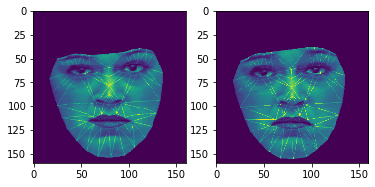

In [13]:
pairPlot(augmented_images_df[['neutralised_image']].iloc[105].to_numpy()[0], augmented_images_df[['crop_original_image']].iloc[105].to_numpy()[0])

In [65]:
def normalise_conf(conf_list):
    # return normalised list with the sum equal to 100
    conf_sum = max(conf_list)
    return [float(x)/conf_sum*100 for x in conf_list]

# Fisher Face

In [14]:
fishface = cv2.face.FisherFaceRecognizer_create() #Initialize fisher face classifier
fishface.train(X_rec_origin_train['all_images'].to_numpy(), y_rec_origin_train.to_numpy(dtype=np.int32))

[2019-12-14 09:55:51] 0.0% is done
[2019-12-14 09:55:54] 30.303030303030305% is done
[2019-12-14 09:55:58] 60.60606060606061% is done
[2019-12-14 09:56:01] 90.9090909090909% is done
Emotion Acc:  94.66666666666667


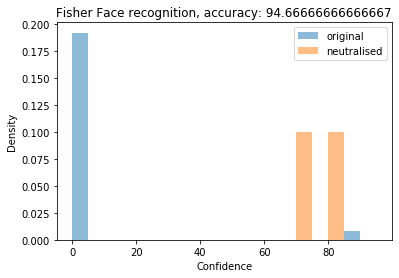

In [73]:
correct = 0
incorrect = 0
fish_confidences_original = []
fish_confidences_neutralised = []
for cnt, image in enumerate(X_rec_origin_test['all_images']):
    pred, conf = fishface.predict(image)

    if np.array_equal(image , X_rec_origin_test['crop_original_image'][cnt]):
        fish_confidences_original.append(conf)
    elif np.array_equal(image , X_rec_origin_test['neutralised_image'][cnt]):
        fish_confidences_neutralised.append(conf)
    else:
        pass #should never happen
    
    if pred == np.array(y_rec_origin_test)[cnt]:
        correct += 1
    else:
        incorrect += 1

    if cnt % 500 == 0:
        print("[{}] {}% is done".format(strftime("%Y-%m-%d %H:%M:%S", gmtime()), str(cnt/len(X_rec_origin_test) * 100)))

fish_acc = (100*correct)/(correct + incorrect)
print('Emotion Acc: ', fish_acc)

plt.hist(fish_confidences_original, density=True, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(fish_confidences_neutralised, density=True, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Fisher Face recognition, accuracy: {}'.format( fish_acc))
plt.savefig('FisherFacerecognition.png')
plt.legend()

In [53]:
print(max(fish_confidences_original), max(fish_confidences_neutralised), min(fish_confidences_original), min(fish_confidences_neutralised))
fish_confidences_original[:10]

2895.252677427716 1502.8138828715232 0.0 73.1483730165299


[1244.1767095415755,
 1258.5413826520673,
 475.24790894275117,
 467.30571552444775,
 1309.8225101420758,
 652.8057149144972,
 676.7940456922134,
 1643.917700485793,
 1040.6473891365858,
 934.1164146467229]

In [18]:
print(fishface.predict(X_rec_origin_test['crop_original_image'][10]), y_rec_origin_test[10], 
      fishface.predict(X_rec_origin_test['neutralised_image'][10]), y_rec_origin_test[10])

(135, 475.24790894275117) 135 (135, 200.65889672257163) 135


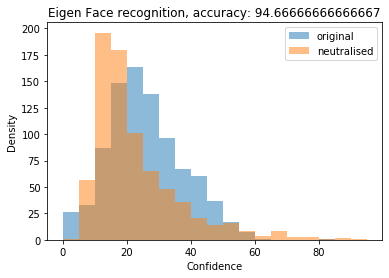

In [83]:
norm_fish_confidences_original = normalise_conf(fish_confidences_original)
norm_fish_confidences_neutralised = normalise_conf(fish_confidences_neutralised)

plt.hist(norm_fish_confidences_original, density=False, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(norm_fish_confidences_neutralised, density=False, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Eigen Face recognition, accuracy: {}'.format(fish_acc))
plt.savefig('FisherFacerecognition_1.png')
plt.legend()

In [27]:
fishface.save('fishface.xml')

# Eigen Face

In [19]:
eigenface = cv2.face.EigenFaceRecognizer_create()
eigenface.train(X_rec_origin_train['all_images'].to_numpy(), y_rec_origin_train.to_numpy(dtype=np.int32))

[2019-12-14 09:56:50] 0.0% is done
[2019-12-14 09:59:01] 30.303030303030305% is done
[2019-12-14 10:00:51] 60.60606060606061% is done
[2019-12-14 10:02:35] 90.9090909090909% is done
Emotion Acc:  99.75757575757575


/Users/akulmehra/anaconda3/envs/ComputerVision/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


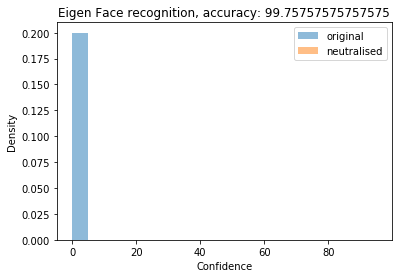

In [75]:
correct = 0
incorrect = 0
eigen_confidences_original = []
eigen_confidences_neutralised = []
for cnt, image in enumerate(X_rec_origin_test['all_images']):
    pred, conf = eigenface.predict(image)
    
    if np.array_equal(image , X_rec_origin_test['crop_original_image'][cnt]):
        eigen_confidences_original.append(conf)
    elif np.array_equal(image , X_rec_origin_test['neutralised_image'][cnt]):
        eigen_confidences_neutralised.append(conf)
    else:
        print('WHY IT HAPPENS: ', cnt)
        pass #should never happen
    
    if pred == np.array(y_rec_origin_test)[cnt]:
        correct += 1
    else:
        incorrect += 1

    if cnt % 500 == 0:
        print("[{}] {}% is done".format(strftime("%Y-%m-%d %H:%M:%S", gmtime()), str(cnt/len(X_rec_origin_test) * 100)))

eigen_acc = (100*correct)/(correct + incorrect)
print('Emotion Acc: ', eigen_acc)

plt.hist(eigen_confidences_original, density=True, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(eigen_confidences_neutralised, density=True, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Eigen Face recognition, accuracy: {}'.format( eigen_acc))
plt.savefig('EigenFacerecognition.png')
plt.legend()

In [50]:
len(eigen_confidences_original), len(eigen_confidences_neutralised)

(883, 767)

In [51]:
print(max(eigen_confidences_original), max(eigen_confidences_neutralised), min(eigen_confidences_original), min(eigen_confidences_neutralised))
eigen_confidences_original[:10]

9098.034140872373 4166.0569812308995 0.0 250.98385444553335


[2468.5159152929778,
 2992.4553887269076,
 1739.7224617965871,
 1567.962624295146,
 4480.771450644747,
 2051.9330526232125,
 2478.586696416222,
 2327.960648161479,
 3264.6443756517424,
 3073.5779618753386]

In [21]:
print(eigenface.predict(X_rec_origin_test['crop_original_image'][10]), y_rec_origin_test[10], 
      eigenface.predict(X_rec_origin_test['neutralised_image'][10]), y_rec_origin_test[10])

(135, 1739.7224617965871) 135 (135, 857.8825880284327) 135


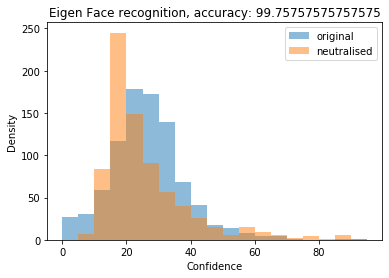

In [82]:
norm_eigen_confidences_original = normalise_conf(eigen_confidences_original)
norm_eigen_confidences_neutralised = normalise_conf(eigen_confidences_neutralised)
plt.hist(norm_eigen_confidences_original, density=False, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(norm_eigen_confidences_neutralised, density=False, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Eigen Face recognition, accuracy: {}'.format(eigen_acc))
plt.savefig('EigenFacerecognition_1.png')
plt.legend()

In [28]:
eigenface.save('eigenface.xml')

# LBHP 

In [22]:
lbph_face = cv2.face.LBPHFaceRecognizer_create()
lbph_face.train(X_rec_origin_train['all_images'], y_rec_origin_train.to_numpy(dtype=np.int32))

[2019-12-14 10:03:08] 0.0% is done
[2019-12-14 10:04:38] 30.303030303030305% is done
[2019-12-14 10:06:06] 60.60606060606061% is done
[2019-12-14 10:08:03] 90.9090909090909% is done
Emotion Acc:  99.93939393939394


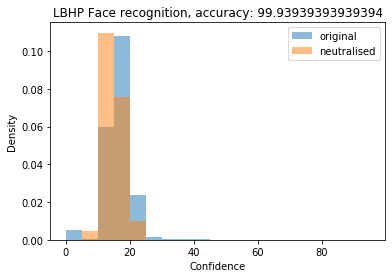

In [78]:
correct = 0
incorrect = 0
lbph_confidences_original = []
lbph_confidences_neutralised = []
for cnt, image in enumerate(X_rec_origin_test['all_images']):
    pred, conf = lbph_face.predict(image)
    
    if np.array_equal(image , X_rec_origin_test['crop_original_image'][cnt]):
        lbph_confidences_original.append(conf)
    elif np.array_equal(image , X_rec_origin_test['neutralised_image'][cnt]):
        lbph_confidences_neutralised.append(conf)
    else:
        pass #should never happen
    
    if pred == np.array(y_rec_origin_test)[cnt]:
        correct += 1
    else:
        incorrect += 1

    if cnt % 500 == 0:
        print("[{}] {}% is done".format(strftime("%Y-%m-%d %H:%M:%S", gmtime()), str(cnt/len(X_rec_origin_test) * 100)))

lbhp_acc = (100*correct)/(correct + incorrect)        
print('Emotion Acc: ', lbhp_acc)

plt.hist(lbph_confidences_original, density=True, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(lbph_confidences_neutralised, density=True, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('LBHP Face recognition, accuracy: {}'.format(lbhp_acc))
plt.savefig('LBHPFacerecognition.png')
plt.legend()

In [24]:
print(lbph_face.predict(X_rec_origin_test['crop_original_image'][10]), y_rec_origin_test[10], 
      lbph_face.predict(X_rec_origin_test['neutralised_image'][10]), y_rec_origin_test[10])

(135, 13.113532421960866) 135 (135, 11.968309528293371) 135


In [37]:
# im_indx = 355
# pairPlot(images_df.iloc[im_indx]['neutralised_image'],images_df.iloc[im_indx]['original_image'])

In [26]:
print(lbph_face.predict(X_rec_origin_test['crop_original_image'][im_indx]), y_rec_origin_test[im_indx], 
      lbph_face.predict(X_rec_origin_test['neutralised_image'][im_indx]), y_rec_origin_test[im_indx])

(501, 20.90148888747829) 501 (501, 0.0) 501


In [29]:
lbph_face.save('lbph.xml')

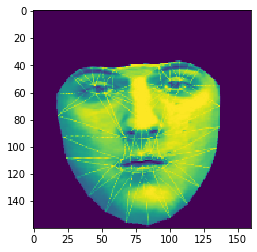

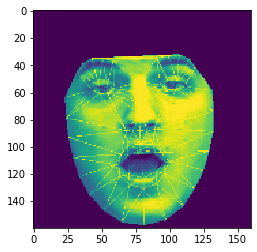

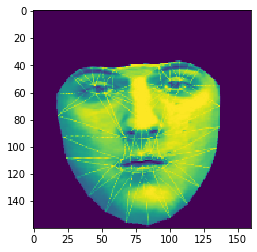

In [33]:
for i in ['all_images', 'crop_original_image', 'neutralised_image']:
    plt.imshow(X_rec_origin_train.iloc[220][i])
    plt.show()

In [48]:
print(max(lbph_confidences_original), max(lbph_confidences_neutralised), min(lbph_confidences_original), min(lbph_confidences_neutralised))
lbph_confidences_original[:10]

40.17348271059848 24.909321347055485 0.0 6.0209337479220055


[17.67419323354893,
 14.500381722309516,
 13.113532421960866,
 14.581574993755016,
 18.59220028883664,
 17.710160400775393,
 15.56811487892794,
 15.050437131355448,
 18.423114261865383,
 19.30669827075758]

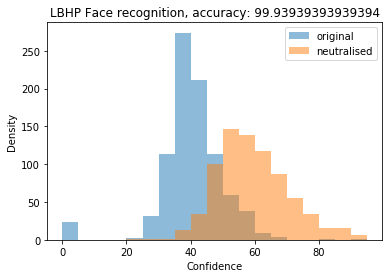

In [79]:
norm_lbph_confidences_original = normalise_conf(lbph_confidences_original)
norm_lbph_confidences_neutralised = normalise_conf(lbph_confidences_neutralised)
plt.hist(norm_lbph_confidences_original, density=False, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(norm_lbph_confidences_neutralised, density=False, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('LBHP Face recognition, accuracy: {}'.format(lbhp_acc))
plt.savefig('LBHPFacerecognition_1.png')
plt.legend()